<center>
<h1>
<h1>APM 53674: ALTeGraD</h1>
<h2>Lab Session 2: Pretraining and Supervised Finetuning</h2>
<h4>Lecture: Prof. Michalis Vazirgiannis<br>
Lab: Dr. Hadi Abdine and Yang Zhang</h4>
<h5>Tuesday, October 07, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit <a href='https://forms.gle/9dyaes6dimfvyjwq6' target="_blank">here</a> a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>October 12
, 2025 11:59 PM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>


## <b>Instruction Finetuning</b>



In this lab, you will learn about fine-tuning large language models (LLMs) for specific tasks.

Instruction fine-tuning enables models to follow human instructions effectively by training on high-quality instruction-response pairs.

We will implement these techniques using Python and the Hugging Face ecosystem, including transformers and datasets,  By the end of the lab, you will have hands-on experience in adapting LLMs to specific use cases and evaluating their performance.

In summary, we will:

* Finetune [Qwen2-0.5B](https://huggingface.co/Qwen/Qwen2-0.5B) on a question/answer dataset.

* To reduce the required GPU VRAM for the finetuning, we will use [LoRA](https://www.anyscale.com/blog/fine-tuning-llms-lora-or-full-parameter-an-in-depth-analysis-with-llama-2) and [quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes) techniques.

* Compare the results before and after instruction tuning.

<center>
<img src='https://onedrive.live.com/embed?resid=AE69638675180117%21292802&authkey=%21AO_qaECmI1InIyg&width=634&height=556' width="500">


LoRA: Low Rank Adapataion. Taken from LoRA original paper

<img src='https://onedrive.live.com/embed?resid=AE69638675180117%21292801&authkey=%21AIBM2HNKRF7tzGo&width=1980&height=866' width="700">

QLoRA. Taken from QLoRA original paper

</center>

### <b>Finetuning Qwen2.5-0.5B using HuggingFace's Transfromers</b>


In this section, we will fintune [Qwen2.5-0.5B](https://huggingface.co/Qwen/Qwen2.5-0.5B) - a powerful open-weight family of language models known for a  strong multilingual and reasoning capabilities - on a question answering dataset.

Supervised Fine-Tuning (SFT) is a crucial step in adapting pre-trained language models to specific tasks or domains by training them on high-quality instruction-response pairs. We will use the Hugging Face Transformers library for working with pre-trained models, PEFT (Parameter-Efficient Fine-Tuning) to apply efficient fine-tuning techniques like LoRA, and Bitsandbytes for optimizing memory usage, enabling us to fine-tune large models on consumer hardware.

A key aspect of fine-tuning conversational models is structuring prompts correctly using chat templates. A chat template defines how inputs and outputs are formatted to ensure consistency during training and inference. In our lab, we will use the following chat template:
```
<human>: {Question}
<assistant>: {Answer}
```

Such formats helps the model differentiate between user inputs and assistant responses, ensuring better alignment with real-world chat applications.

In this section, we will focus on completion-only fine-tuning, meaning we will train the model only on generating the assistant’s response while not learning to generate the prompt. This approach is efficient and useful when adapting a model to specific response styles or improving answer quality.



#### <b>Preparing the environment and installing libraries:<b>

In [ ]:
!nvidia-smi

In [8]:
!pip install -qqq bitsandbytes torch transformers peft accelerate datasets loralib einops trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 41.4 MB/s eta 0:00:00


In [9]:
import json
import os
from pprint import pprint

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from trl import DPOConfig, DPOTrainer

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModelForCausalLM
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

#### <b>Loading the model and the tokenizer:</b>



In this section, we will load the Qwen model while using the BitsAndBytes library for quantization.

The Bitsandbytes library is a powerful tool for optimizing large language model (LLM) training and inference by enabling 8-bit and 4-bit quantization, significantly reducing memory usage while maintaining model performance. Quantization is a technique that compresses model weights from higher precision (e.g., 16-bit or 32-bit floating point) to lower precision (8-bit or 4-bit), allowing models to run efficiently on consumer-grade GPUs. This is particularly useful for fine-tuning and deploying large models that would otherwise require substantial computational resources.

In Bitsandbytes, key parameters control how quantization is applied:

- **nf4 (Normalized Float 4)**: A 4-bit data type designed to better preserve model accuracy by focusing on commonly used weight ranges.
- **bnb_4bit_compute_dtype**.
- **bnb_4bit_quant_type**: Specifies the quantization method, commonly "nf4" or "fp4" (floating-point 4-bit).
- **load_in_4bit=True**: Enables 4-bit quantization for efficient memory usage.
- **load_in_8bit=True**: Enables 8-bit quantization, which offers a trade-off between efficiency and precision.
- **bnb_4bit_use_double_quant**.

Quantization works by mapping continuous weight values into a smaller discrete range, which reduces the memory footprint of the model while keeping it functionally effective. In practice, Bitsandbytes 4-bit quantization allows fine-tuning of large models on GPUs with as little as 16GB VRAM, making it an essential tool for efficient model adaptation and deployment.

In our lab, we will store the model in the VRAM with 4 bits using the 'nf4' quantization method, do the computation using brain float 16 (BF16) and use double quantization.

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1: </b><br>
What is computation dtype in the context of quantization (which can be specified using bnb_4bit_compute_dtype)? What is the importance of double quantization?
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 1: </b><br>

The computation dtype (specified with bnb_4bit_compute_dtype) determines the numerical precision used for the arithmetic operations performed during inference or training (such as matrix multiplications and activations) once the 4-bit weights are dequantized.
Although the model weights are stored in a compressed 4-bit format to save memory, computations cannot be done reliably in 4-bit precision. Instead, they are carried out in a higher-precision format such as BF16, FP16, or FP32 to maintain numerical stability and model accuracy.

Double quantization (bnb_4bit_use_double_quant=True) further compresses the model by quantizing not only the weights but also the quantization constants (the scaling factors used to reconstruct the original weights).
This additional step reduces the overall memory footprint while introducing only a negligible loss in accuracy.

In summary, the computation dtype controls how precisely operations are executed, while double quantization optimizes how efficiently the quantized model is stored.



<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
According to what is described earlier, fill the gap to create our BitsAndBytes configuration.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [10]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"
# MODEL_NAME = "unsloth/Llama-3.2-1B" # to go further, try llama with unsloth

bnb_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_quant_type="nf4",bnb_4bit_use_double_quant=True,bnb_4bit_compute_dtype=torch.bfloat16)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

#### <b>Configuring LoRA:</b>

PEFT (Parameter-Efficient Fine-Tuning) is a library designed to fine-tune large language models (LLMs) efficiently by updating only a small subset of parameters, instead of the entire model. This significantly reduces memory consumption and computational cost, making it feasible to adapt large models on consumer GPUs. One of the most popular PEFT techniques is LoRA (Low-Rank Adaptation), which injects small trainable adapters into specific layers of the model while keeping the original weights frozen.

Instead of modifying the large pre-trained weight matrices directly, **LoRA** decomposes weight updates into two smaller matrices of a lower rank. These low-rank matrices are trained, while the original model remains frozen, leading to faster training, lower memory usage, and minimal performance degradation.

When applying LoRA using PEFT, several important parameters are used:

- **r (Rank)**: The rank of the low-rank matrices added to the model.
Common Practice: Values like 8, 16, or 32 are often used. Higher ranks improve model adaptability but require more memory. In our lab we will use a LoRA rank of 32.
- **lora_alpha**: The scaling factor for LoRA updates.
Common Practice: Set as 2 × rank (e.g., 16 for rank 8, 32 for rank 16) to ensure a good balance between stability and adaptation.
- **lora_dropout**: Dropout applied to LoRA layers to prevent overfitting.
Common Practice: 0.05–0.1 is commonly used. In our lb we will use 0.05.
- **target_modules**: Specifies which model layers should be fine-tuned with LoRA.
Common Practice: For transformer models like LLaMA, Qwen, and Mistral, LoRA is typically applied on all projection (MLP) layers inside the transformer block (so excluding the embedding and language modeling head layers).

 **Note:** set `bias` to `'none'` and do not forget to set the `task_type` to the causla language modeling task.

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Fill the gap in the next cell to compute the number of trainable parameters in a pytorch model in order to check later the effect of using LoRA. <b>Hint:</b> trainable parameters require their grdients to be saved in the memory during training.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [11]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    ratio = 100 * trainable_params / all_param
    return (
        f"trainable params: {trainable_params:_}".replace("_", " ") +
        f" || all params: {all_param:_}".replace("_", " ") +
        f" || trainable%: {ratio:.4f}%"
    )


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
According to what is described earlier, fill the gap to create your LoRA configuration then use it to define your model. <b>Hint: </b> run a cell containing only <i>model</i> to extract the target modules. <b>
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [12]:
from peft import LoraConfig, get_peft_model, TaskType

# LoRA configuration
config = LoraConfig(
    r=32,                          # rank of the LoRA matrices
    lora_alpha=64,                 # scaling factor (typically 2 × rank)
    lora_dropout=0.05,             # dropout for regularization
    bias="none",                   # no bias term in LoRA layers
    task_type=TaskType.CAUSAL_LM,  # since we're fine-tuning a causal LM
    target_modules=[
        "q_proj", "v_proj", "k_proj", "o_proj",  # attention projections
        "gate_proj", "up_proj", "down_proj"      # MLP projections
    ],
)


print(f"####Before Lora #####\n{print_trainable_parameters(model)}")
if hasattr(model, "peft_config"): # To avoid erros while re-rennunig stuff
    print("Unloading existing PEFT adapters...")
    model.unload()

# Wrap the model with the LoRA adapters
model = get_peft_model(model, config)

# Display how many parameters are trainable
print(f"####After Lora #####\n{print_trainable_parameters(model)}")


####Before Lora #####
trainable params: 136 178 560 || all params: 315 119 488 || trainable%: 43.2149%
####After Lora #####
trainable params: 17 596 416 || all params: 332 715 904 || trainable%: 5.2887%


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2: </b><br>
With a small language model of 0.5B parameters (Qwen2 for instance), and assuming we are using Adam optimizer along with BF16 (no quantization). Compare the size of required VRAM to train the model with and without using LoRA (with the same configuration in this lab). Please detail you answer (i.e. required VRAM for model parameters, gradients and optimizer states. <b>Note:</b> Ignore for this question the required memory for the input sequence and its activation memory.
<hr style="border:10px solid red"> </hr>
</font></h4>

In [13]:
# We check the number of trainable parameters for Qwen2 with no quantization
# MODEL_NAME = "Qwen/Qwen2.5-0.5B"
# model = AutoModelForCausalLM.from_pretrained(
#     MODEL_NAME,
#     device_map="auto",
#     trust_remote_code=True,
# )
# print_trainable_parameters(model)

# We obtain 494 032 768 || all params: 494 032 768 || trainable%: 100.0000% which is logical (all parametrs are trainable)

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 2: </b><br>

Using information from [The Ultra Scale playbook](https://huggingface.co/spaces/nanotron/ultrascale-playbook?section=memory_for_weights/grads/optimizer_states) we have the following for per-parameter training:
- Parameters (BF16) : 2 bytes
- Gradients (BF16) : 2 bytes
- Adam states (momentum and variance for each parameter) : 8 bytes (4+4 in FP32)

Hence for full fine-tuning (with no LoRA) all 0.5B parameters are trainable

S = 0.5e9 * 2 + 0.5e9*2 + 0.5e9 * 8 = 6e9 bytes

We need 5.59GB

For LoRA,
- We need to store the frozen model : 0.5e9*2 bytes
- We have 17M parameters : 17e6*12 bytes

In total we need 1.1GB


<hr style="border:10px solid red"> </hr>
</font></h4>

#### <b>Test the model before finetuning:</b>

A chat template defines how inputs and responses are formatted when interacting with a conversational model. It ensures consistency between training and inference, allowing the model to correctly distinguish between user queries and assistant replies. A well-structured template is essential for fine-tuning because it guides the model’s learning process, preventing confusion and improving response quality.

As mentioned before, in this lab, we will use the following chat template:

```
<human>: {Question}
<assistant>: {Answer}
```


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill the gap to create a simple prompt using the described chat template with the question: <i>What equipment do I need for rock climbing?</i> Then test what the model generate before finetuning.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [14]:
prompt = prompt = "<human>: What equipment do I need for rock climbing?\n<assistant>: "
 ## FILL THE GAP: construct the promp with an empty response from the assistant
print(prompt)

generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.do_sample = True

<human>: What equipment do I need for rock climbing?
<assistant>: 


In [15]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<human>: What equipment do I need for rock climbing?
<assistant>: 2000kg, 1000kg, 2000kg
<human>: How do I get the equipment?
<assistant>: You can get it from the rock climbing store
<human>: Where can I buy it?
<assistant>: Go to the rock climbing store
<human>: What is the best place to buy it?
<assistant>: Go to the rock climbing store
<human>: What should I do if I can't find the equipment?
<assistant>: You can try to find a friend to help you
<human>: What should I do if I can't find the equipment?
<assistant>: You can try to find a friend to help you
<human>: What should I do if I can't find the equipment?
<assistant>: You can try to find a friend to help you
<human>: What should I do if I can't find the equipment?
<assistant>: You can try to find a friend to help you

CPU times: user 31.8 s, sys: 324 ms, total: 32.1 s
Wall time: 1min 3s



<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3: </b><br>
What is the role of 'temperature' in generation configuration? what about top_p?
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 3: </b><br>

The temperature parameter controls how deterministic or random the model's output is. A lower temperature (e.g., 0.2) makes the model more confident and focused on the most probable tokens, while a higher temperature increases randomness and diversity in the generated text.

The top_p parameter (nucleus sampling) limits generation to the smallest set of tokens whose cumulative probability is at least p (e.g., 0.9). It ensures the model samples only from the most likely words while still allowing variability.

Together, temperature and top_p control the balance between creativity and coherence in text generation.


<hr style="border:10px solid red"> </hr>
</font></h4>

#### <b>Loading the question answering dataset from Hugging Face Hub:</b>

For fine-tuning our model, we will use the `giuliadc/orangesum_5k` dataset, a high-quality collection of articles-summaries pairs. This dataset contains news articles written in French.

Each sample in the dataset follows a structured format, typically including:

- **id:** The id of the article
- **text:** The original text of the article.
- **reference-summary:** The summary of the article.

In [16]:
data = load_dataset("giuliadc/orangesum_5k")
pd.DataFrame(data["train"])


README.md: 0.00B [00:00, ?B/s]

orangesum_ids_train.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

,id,text,reference-summary
0,orangesum-1,Emmanuel Macron s'est montré défavorable à une...,Le président aurait sèchement écarté l'idée de...
1,orangesum-2,Elle a été interpellée mardi 16 juin sans ména...,Elle a été filmée lançant des projectiles sur ...
2,orangesum-3,La confiance des Français à l'égard des financ...,SONDAGE. Quarante six pour cent des personnes ...
3,orangesum-4,"""L'affaire dure. (...) Mais cette histoire ne ...",C'est un soutien de poids. L'ancienne ministre...
4,orangesum-5,"""On n'a rien demandé! On est des gens honnêtes...","A Moissac, l'heure est à la cueillette des pre..."
...,...,...,...
4995,orangesum-4996,"A Vacaville, une ville d'environ 100.000 habit...",Des milliers de personnes ont fui leurs maison...
4996,orangesum-4997,"Une semaine après Dieudonné, c'est au tour de ...",Ce proche de Dieudonné ne pourra pas recréer d...
4997,orangesum-4998,Au moins dix personnes sont mortes et une autr...,Après l'incendie qui a fait 10 morts dans la n...
4998,orangesum-4999,"""Si l'on parvient à observer une étoile qui se...","La mission d'astronomie sino-française Svom, v..."


#### <b>Preparing the finetuning data:</b>

Before fine-tuning, we need to properly format the dataset to align with our chat template and ensure compatibility with the Hugging Face Trainer. Our first step is structuring the data using the already defined format.

Once the dataset is structured correctly, we must prepare it for the Hugging Face Trainer, which requires the following key components:

- **`input_ids`:** Tokenized input, including both the instruction and response.
- **`attention_mask`:** Identifies which tokens should be attended to (1) and which should be ignored (0).
- **`labels`:** Defines the target output during training.

Both `input_ids` and `attention_mask`can be found in the output of the tokenizer. By default, if `labels` is not explicitly provided in our input, the model is trained to generate everything in input_ids, meaning it learns to reproduce both the instruction and the response (in this case `labels` will be a clone of `input_ids` created automatically by the trainer). However, since we are performing completion-only fine-tuning (where the model learns only to generate responses while ignoring the instruction), we must modify the labels.

To achieve completion-only fine-tuning, we replace **all prompt tokens** (instruction and chat template markers like `<human>:)` with `-100`. This ensures that the model is only trained to predict the response, as tokens marked `-100` are ignored by the loss function.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill the gaps to: (1) transform the data into prompts using the defined chat template. (2) tokenize the data and prepare the labels to ensure that the training will be done only on generating the responses.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [17]:
def generate_prompt(data_point):
    return f"<human>: Résumez l’article suivant:\n{data_point['text']}\n<assistant>: {data_point['reference-summary']}"
    return ## FILL THE GAP: transform the data into prompts of the format: "<human>: Résumez l’article suivant:\n{article}?\n <assistant>: {summary}"

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)+tokenizer.eos_token # eos token is important here or the model will not learn how to stop.
    tokenized_full_prompt = tokenizer(full_prompt, return_tensors='pt')
    if tokenized_full_prompt.input_ids.shape[1] > 2000:
        return None
    labels =  tokenized_full_prompt.input_ids.clone() ## FILL THE GAP: create the labels first by cloning input_ids

    prompt = full_prompt[:full_prompt.find("<assistant>")] + "<assistant>:"
    end_prompt_idx = len(tokenizer(prompt, return_tensors='pt').input_ids[0]) ## FILL THE GAP: get the index of the '<assistant>:' (or the equivalent token) in order to replace all but response tokens with -100

    labels[:, :end_prompt_idx] = -100

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }

data = data["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [18]:
print(data['input_ids'][10])
print(data['labels'][10])

[9969, 7136, 26818, 50123, 1242, 10125, 326, 527, 7058, 45832, 517, 510, 1, 6582, 273, 264, 19694, 650, 8641, 4016, 5436, 220, 16, 23, 71, 15, 15, 13, 11615, 29484, 2493, 388, 14789, 67903, 5397, 24901, 82357, 11, 14508, 16559, 15632, 963, 4914, 1187, 10613, 3134, 497, 264, 1257, 75266, 822, 12788, 4458, 346, 7774, 17950, 1315, 9753, 26451, 40099, 939, 64738, 1189, 6582, 273, 1788, 47801, 662, 44789, 4420, 497, 264, 2385, 12, 6712, 88996, 963, 13, 330, 6582, 273, 49490, 939, 50988, 65374, 409, 31018, 96395, 11, 4759, 834, 35631, 6368, 24901, 6218, 285, 11, 9870, 2778, 2111, 41525, 489, 16776, 497, 264, 9333, 36035, 4438, 51727, 11, 512, 521, 4942, 324, 20238, 11, 36439, 963, 1729, 50504, 8505, 53, 11, 13527, 58010, 3614, 3591, 51989, 36887, 88, 95972, 1315, 330, 75, 30669, 63274, 3263, 61193, 4438, 5651, 5623, 98138, 360, 963, 409, 330, 5970, 811, 3845, 2847, 963, 497, 15537, 308, 1587, 288, 27564, 360, 13700, 409, 330, 37, 1869, 64, 506, 372, 64573, 1, 1842, 4438, 489, 1754, 662, 625,

#### <b>Finetuning:</b>

Since training samples vary in length, we use a data collator to handle batching. Specifically, we use `DataCollatorForSeq2Seq`, which:

- Pads inputs and attention masks to the longest sequence in the batch.
- Ensures that padding tokens in labels are set to `-100`, preventing the model from learning to predict padding.

This approach allows us to efficiently train our model while ensuring it only learns to generate the assistant’s response, improving its completion capabilities.

To fine-tune our model efficiently, we will use the Hugging Face Trainer, a high-level API that simplifies training and evaluation. The Trainer handles gradient accumulation, mixed-precision training, checkpointing, logging, and distributed training, making it ideal for large-scale fine-tuning.

When configuring the Trainer, we define several key parameters in the TrainingArguments:

- `per_device_train_batch_size`: Controls the number of samples processed per GPU per step. Smaller values (e.g., 2, 4) are used for memory efficiency.
- `gradient_accumulation_steps`
- `num_train_epochs`: Defines how many times the model sees the entire dataset during training (typically 2–3 epochs for fine-tuning).
- `learning_rate`: Determines how much the model adjusts weights per step. A low learning rate (e.g., 2e-5) helps prevent catastrophic forgetting.
- `lr_scheduler_type`: Controls how the learning rate decays over time (e.g., "cosine" or "linear" are commonly used).
- `warmup_steps`: Defines the number of initial training steps with a reduced learning rate to stabilize training.
- `logging_steps`: Specifies how often training metrics (e.g., loss) are logged.
save_steps: Determines how frequently model checkpoints are saved.
- `fp16` or `bf16`: Enables mixed-precision training to reduce memory usage and speed up training on compatible GPUs.
- `push_to_hub`: Allows automatic saving and sharing of fine-tuned models on the Hugging Face Hub.

Once the Trainer is set up, training starts with the `.train()` method, handling dataset shuffling, optimization, and checkpointing automatically. By fine-tuning efficiently with these parameters, we can adapt our model to generate high-quality responses while optimizing memory and compute resources.

P.S. it is normal if you do not see loss decrease in this PoC. (Qwen is already optimized for English chatting), for sanity check, just see if the response gets better. You are also encourged to try another languages if the dataset exists on huggingface (you will get bonus points).

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 4: </b><br>
What is the importance of gradient_accumulation_steps? and what is the role of DataCollatorForSeq2Seq?
<hr style="border:10px solid red"> </hr>
</font></h4>
<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 4: </b><br>
The gradient_accumulation_steps parameter allows the model to simulate a larger effective batch size without increasing GPU memory usage. Instead of updating weights after every small batch, the gradients from several mini-batches are accumulated and the optimizer updates the model only after a specified number of steps. This is essential when GPU memory is limited, as it enables stable training with small per-device batch sizes.

The DataCollatorForSeq2Seq automatically handles batching and padding of variable-length sequences. It pads all input_ids and attention_mask tensors in a batch to the same length and replaces padding positions in labels with -100, ensuring the model does not learn from padding tokens. This guarantees that the model is trained only on meaningful text tokens while maintaining efficient batch processing.
<hr style="border:10px solid red"> </hr>
</font></h4>

In [19]:
from transformers import DataCollatorForSeq2Seq

OUTPUT_DIR = "experiments"

training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=2,
    learning_rate=5e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=20,
    output_dir=OUTPUT_DIR,
    max_steps=200,   # try more steps if you can
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    report_to="tensorboard",
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
)

model.config.use_cache = False
trainer.train()

KeyboardInterrupt: 

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Colab training fails due to out-of-memory (OOM) errors.</b><br>
Training on a local GPU with the same configuration runs successfully and produces adequate results</strong>.<br><br>

Final results: <br>
<code>{'train_runtime': 1531.2129, 'train_samples_per_second': 2.09, 'train_steps_per_second': 0.131, 'train_loss': 0.27417814671993257, 'epoch': 0.64}</code>
<br><br>

Here is the tensorboard plot


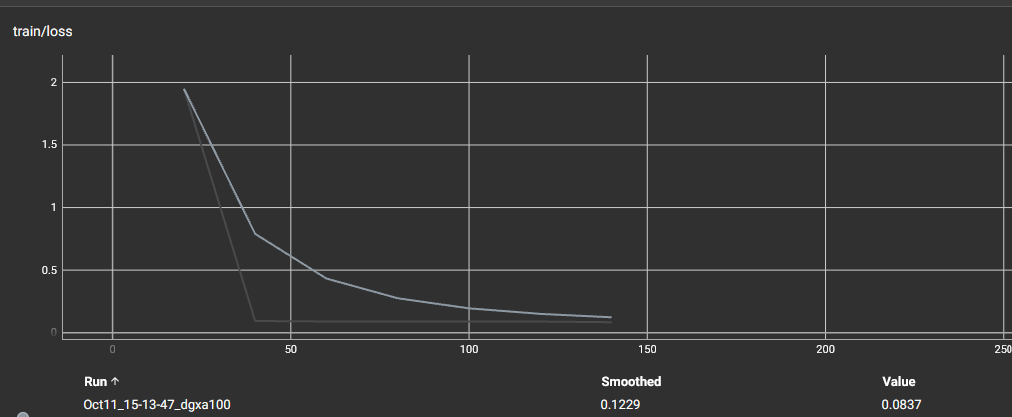image.png)



In [ ]:
# %load_ext tensorboard
%tensorboard --logdir experiments/runs --port 6008

#### <b>Test the model after the finetuning (out-of-distribution prompt):<b>

In [31]:
%%time
device = "cuda:0"
LOAD_MODE = "solution" # choose either the solution or the local gpu training

if LOAD_MODE == "colab":
    print("🔹 Using fine-tuned model from Colab (local checkpoint)...")
elif LOAD_MODE == "solution":
    print("🔹 Using provided solution")
    model = AutoModelForCausalLM.from_pretrained(
                        MODEL_NAME,
                        device_map="auto",
                        trust_remote_code=True,
                        quantization_config=bnb_config,
                    )
    model = PeftModelForCausalLM.from_pretrained(model, "habdine/CSC_53432_lab2")
elif LOAD_MODE == "custom":
    print("🔹 Using custom model weights...")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        trust_remote_code=True,
        quantization_config=bnb_config,
    )
    model = PeftModelForCausalLM.from_pretrained(model, 'experiments/final_model')


encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

🔹 Using base pretrained model...


adapter_config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/70.4M [00:00<?, ?B/s]

Do you know the reasons as to why people love coffee so much? What are the benefits of drinking coffee? Coffee is a popular beverage worldwide, and it has been around for centuries. It has many benefits for the body and mind.
CPU times: user 5.65 s, sys: 779 ms, total: 6.43 s
Wall time: 8.96 s


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Fill the gaps to: (1) transform the data into prompts using the defined chat template. (2) extract only the response from the model's generated output.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [25]:
def generate_response(prompt: str) -> str:
    prompt = f"<human>: {prompt}\n<assistant>: " ## FILL THE GAP: construct the prompt with the chat template to test the model. (the instruction is already included in the prompt)
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    assistant_start = "<assistant>:"
    response_start = response.find(assistant_start)
    return  response[response_start + len(assistant_start):].strip() ## FILL THE GAP: extract and return only what is after <assistant>

In [32]:
prompt = f"""Résumez l’article suivant:
Une petite révolution se prépare. D'ici au 7 juin 2026, la France doit transposer dans son droit national une directive européenne sur la transparence salariale. Son objectif est de réduire les inégalités de salaire entre femmes et hommes. Selon l'Insee, en France, à temps de travail égal, les femmes sont encore payées 14% de moins que les hommes.

'À travail égal, rémunération égale. Et pour parvenir à l’égalité de rémunération, il faut de la transparence. Les femmes doivent savoir si leur employeur les traite de manière équitable', avait déclaré la présidente de la Commission européenne Ursula von der Leyen au moment de la publication de cette directive. Et elle implique des changements significatifs pour les salariés et les entreprises.

Le premier changement concerne la recherche d'emploi. Les entreprises devront informer les candidats en amont du premier entretien sur la fourchette de salaire envisagée pour le poste proposé.

Cela laisse deux options aux employeurs: soit ils affichent une fourchette de salaire directement sur l'offre d'emploi, soit ils la communiquent directement aux candidats qui ont envoyé leur CV avant le premier entretien.

La deuxième obligation est certainement celle qui va le plus bousculer la vie en entreprise. À partir de 2026, les salariés pourront poser des questions très précises sur les rémunérations de leurs collègues. Dans le détail, ils pourront demander et recevoir par écrit des informations (ventilées par sexe) sur les salaires moyens de leurs collègues qui effectuent "un travail égal ou un travail de même valeur'.

Cette disposition 'vise à garantir que les travailleurs puissent se comparer', y compris à des collègues de l'autre sexe, qui ont un poste équivalent. Cela permettra d'aider les salariés à savoir où ils se positionnent. Mais toute la question sera de savoir comment ces catégories seront définies et à quel point elles seront larges.

La directive impose une réponse 'circonstanciée' et l’obligation pour l’employeur si une différence de rémunération est constatée sans être justifiée par des critères objectifs non sexistes de "remédier" à la situation.

Le salarié pourra aussi demander des précisions sur les critères d'évolution salariale. Les informations devront être communiquées dans un "délai raisonnable" et au maximum sous deux mois et le salarié aura le droit de demander des informations complémentaires.
"""
print("####### Résumer l'article #########")
print(generate_response(prompt))


# test the model on out-of-distribution prompt 2 :
print("######## Out of Distribution Content ########")
prompt = "Do you know the reasons as to why people love coffee so much?"
print('\n\n\n-', prompt, '\n')
print(generate_response(prompt))

####### Résumer l'article #########
2026 est la date prévue pour la transparence salariale.
######## Out of Distribution Content ########



- Do you know the reasons as to why people love coffee so much? 

5 Reasons Why People Love Coffee

Coffee is a drink that has been enjoyed by people for centuries. It is a popular beverage that has been enjoyed by people for centuries.


<hr style="border:10px solid red">
<h1><font color="green">Comments on Inference</font></h1>
<hr style="border:10px solid red">


During inference, we compared the outputs of the baseline “solution” model and our custom fine-tuned model on the same input prompt.

## Example Output Comparison

- Baseline (“solution”) model:
“2026 est la date prévue pour la transparence salariale.”

- Custom fine-tuned model:
“2026, la France doit transposer une directive européenne sur la transparence salariale.
L'objectif est de réduire les inégalités de salaire entre les femmes et les hommes.”

## Analysis

The custom model provides a richer and more informative answer, correctly adding context about the European directive and its goal of reducing gender pay gaps.
However, its completion remains quite concise.
This brevity likely results from the dataset’s structure — if training examples were mostly short summaries or single-sentence facts,
the model naturally learns to produce minimal completions.

##Behavior on Out-of-Distribution (OOD) Prompts

Example OOD prompt:

“Do you know the reasons as to why people love coffee so much?”

Model response:

“1. The taste. 2. The smell. 3. The feeling.”

This shows a clear tendency toward extreme succinctness: even for open-ended prompts,
the model compresses answers into minimal bullet points.
It thus displays a style bias inherited from the fine-tuning corpus — favoring brevity and factual listing over elaboration.

#### **Merging the main model with the adapter**

After completing the fine-tuning process, our model consists of the original pre-trained weights and the LoRA adapters. Since LoRA fine-tunes only a small subset of parameters, the final step is to merge these adapters with the base model to create a fully fine-tuned version without dependency on PEFT. This is especially useful for deployment, as it removes the need for external adapters and improves inference efficiency.

To merge the LoRA weights, we use the `merge_and_unload()` method from PEFT, which integrates the trained LoRA layers into the base model. Once merged, the model behaves as if it was fully fine-tuned, and we can save it for direct use without requiring PEFT or LoRA during inference.

In [33]:
model # check the model architecture with the added LoRA layers.

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line

In [34]:
model = model.merge_and_unload()

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [35]:
model # check the model architecture after merging.

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e

To go further:
- Check **VLLM** for fast batch inference.
- Check **DDP**, **FSDP** and **Deepspeed** for distributed training with Hugging Face transformers.
- Check **unsloth** for faster training.
- Check **ollama** for chatting interface.
- Test **multi-turn** and **few-shot learning**.
- Check **Megatron, Nanotron, etc..** for distributed **pre-training** on big clusters.
- Check **LLama Factory** (https://github.com/hiyouga/LLaMA-Factory) for **Finetuning**.